In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [2]:
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder

def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
  
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
    ])

    if test:
        dataset = ImageFolder(
            root=data_dir, transform=transform
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # load the dataset
    train_dataset = ImageFolder(
        root=data_dir, transform=transform
    )

    valid_dataset = ImageFolder(
        root=data_dir, transform=transform
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)

train_loader, valid_loader = data_loader(data_dir='/kaggle/input/architectural-heritage-elements-image64-dataset/train',
                                         batch_size=64)

test_loader = data_loader(data_dir='/kaggle/input/architectural-heritage-elements-image64-dataset/test',
                          batch_size=64,
                          test=True)


In [3]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class ResidualBlock(nn.Module):
    expansion = 1  # Define the expansion factor for this block

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


In [5]:
import torch.nn.functional as F

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0])
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.activations = []  # List to store intermediate feature maps

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        self.activations = []  # Clear activations list before forward pass
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer0(x)
        self.activations.append(x)  # Store activation after layer0

        x = self.layer1(x)
        self.activations.append(x)  # Store activation after layer1

        x = self.layer2(x)
        self.activations.append(x)  # Store activation after layer2

        x = self.layer3(x)
        self.activations.append(x)  # Store activation after layer3

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [6]:
num_classes = 10
num_epochs = 20
batch_size = 16
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

In [7]:
# Lists to store loss and accuracy values
train_loss_values = []
train_accuracy_values = []  # Add a list to store training accuracy values
valid_loss_values = []
valid_accuracy_values = []

for epoch in range(num_epochs):
    # Variables to track loss and accuracy for the current epoch
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        epoch_train_loss += loss.item()
        
        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Compute average loss and accuracy for the epoch
    epoch_train_loss /= len(train_loader)
    train_loss_values.append(epoch_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracy_values.append(train_accuracy)  # Store training accuracy
    
    # Validation
    with torch.no_grad():
        correct_valid = 0
        total_valid = 0
        epoch_valid_loss = 0.0  # Initialize validation loss for the epoch
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Compute validation loss
            epoch_valid_loss += loss.item()  # Accumulate validation loss
            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
        
        # Compute average validation loss and accuracy for the epoch
        epoch_valid_loss /= len(valid_loader)
        valid_loss_values.append(epoch_valid_loss)  # Store validation loss
        valid_accuracy = 100 * correct_valid / total_valid
        valid_accuracy_values.append(valid_accuracy)

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'
           .format(epoch+1, num_epochs, epoch_train_loss, train_accuracy, epoch_valid_loss, valid_accuracy))
    

Epoch [1/20], Train Loss: 1.6423, Train Accuracy: 42.05%, Validation Loss: 1.2427, Validation Accuracy: 57.26%
Epoch [2/20], Train Loss: 1.1166, Train Accuracy: 61.98%, Validation Loss: 1.0960, Validation Accuracy: 60.91%
Epoch [3/20], Train Loss: 0.9317, Train Accuracy: 68.03%, Validation Loss: 0.8340, Validation Accuracy: 71.08%
Epoch [4/20], Train Loss: 0.7552, Train Accuracy: 74.95%, Validation Loss: 0.7462, Validation Accuracy: 73.94%
Epoch [5/20], Train Loss: 0.6159, Train Accuracy: 79.04%, Validation Loss: 0.7381, Validation Accuracy: 74.93%
Epoch [6/20], Train Loss: 0.5307, Train Accuracy: 81.88%, Validation Loss: 0.5712, Validation Accuracy: 80.06%
Epoch [7/20], Train Loss: 0.4469, Train Accuracy: 85.09%, Validation Loss: 0.6079, Validation Accuracy: 81.15%
Epoch [8/20], Train Loss: 0.3706, Train Accuracy: 87.62%, Validation Loss: 0.6199, Validation Accuracy: 80.36%
Epoch [9/20], Train Loss: 0.3142, Train Accuracy: 89.37%, Validation Loss: 0.5262, Validation Accuracy: 83.91%
E

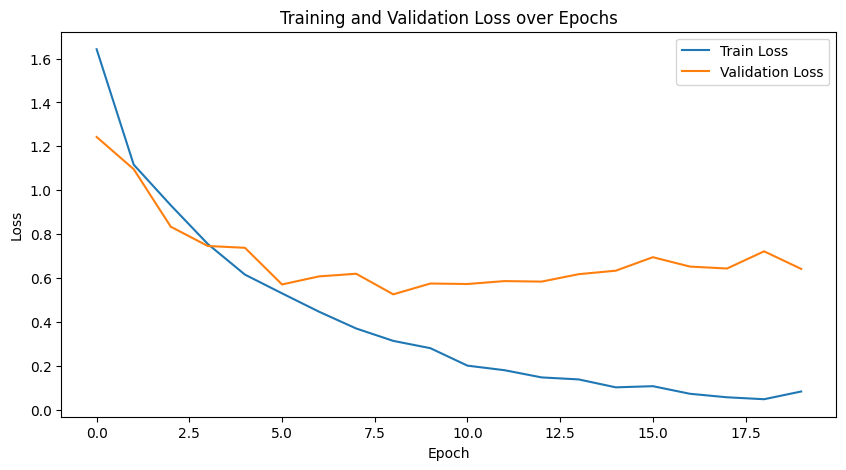

In [9]:
import matplotlib.pyplot as plt
# Plot loss and accuracy graphs
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(valid_loss_values, label='Validation Loss')  # Plot validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

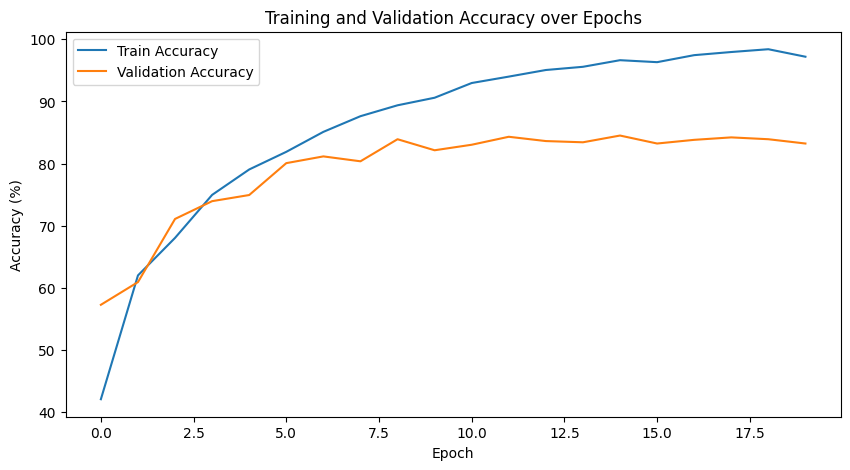

In [10]:

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_values, label='Train Accuracy')
plt.plot(valid_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

In [11]:
import torch
from sklearn.metrics import precision_score, recall_score

# Evaluation
with torch.no_grad():
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    total_test_images = len(test_loader.dataset)   
    print('Accuracy of the network on the {} test images: {:.2f} %'.format(total_test_images, 100 * correct / total))

# Compute precision and recall
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

print('Precision: {:.4f}, Recall: {:.4f}'.format(precision, recall))


Accuracy of the network on the 1404 test images: 80.13 %
Precision: 0.8125, Recall: 0.8013


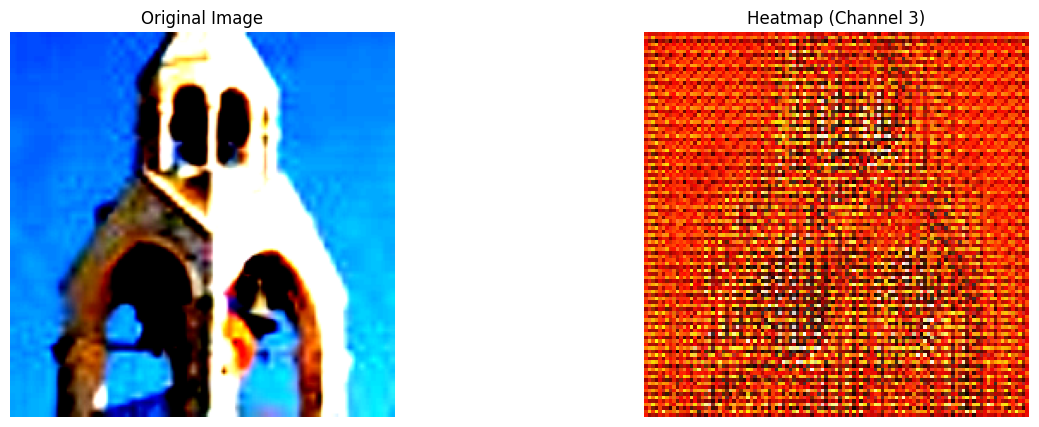

In [15]:
import matplotlib.pyplot as plt
class Visualizer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Visualizer, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()  
        )
        
        self.deconv.to(device)

    def forward(self, x):
        return self.deconv(x)


def visualize_feature_maps(model, image, layer_id=0):
    # Forward pass through the model to get activations
    model(image)
    activations = model.activations
    activation = activations[layer_id]

    # Create visualizer for this layer's feature maps
    visualizer = Visualizer(activation.size(1), 3) 
    activation = activation.unsqueeze(0) if activation.dim() == 3 else activation
    visualized_maps = visualizer(activation)
    return visualized_maps




for images, _ in test_loader:
    image = images[0] 
    break
# Visualize feature maps
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device)
image = image.unsqueeze(0).to(device) 



def plot_heatmap_with_image(heatmap, image, cmap='viridis', alpha=0.6, vmin=None, vmax=None):
    heatmap_numpy = heatmap.cpu().detach().numpy()
    image_numpy = image.squeeze(0).cpu().detach().numpy()

    # Plot the heatmap
    plt.figure(figsize=(15, 5))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_numpy.transpose(1, 2, 0))
    plt.title('Original Image')
    plt.axis('off')


    num_channels = heatmap_numpy.shape[1]
    plt.subplot(1, 2, 2)
    for i in range(num_channels):
        heatmap_channel = heatmap_numpy[0, i, :, :]
        plt.imshow(heatmap_channel, cmap=cmap, interpolation='nearest', alpha=alpha, vmin=vmin, vmax=vmax)
        plt.title(f'Heatmap (Channel {i+1})')
        plt.axis('off')

    plt.show()


visualized_feature_maps = visualize_feature_maps(model, image, layer_id=1)

# Plot the heatmap with the original image
plot_heatmap_with_image(visualized_feature_maps, image, cmap='hot', alpha=0.8, vmin=0.2, vmax=0.8)

In [13]:
class_names = ['altar', 'apse', 'bell tower', 'column', 'dome (inner)',
               'dome (outer)', 'flying buttress', 'gargoyle (and Chimera)', 'stained glass', 'vault']

In [16]:
def generate_image_for_class(model, visualizer, target_class_name, layer_id=0):
    # Get the index of the target class
    target_class_index = class_names.index(target_class_name)

    # Generate a placeholder image with random noise
    placeholder_image = torch.randn(1, 3, 224, 224).to(device)

    # Forward pass through the model to get activations
    model.to(device)  # Move the model to the same device as the input tensor
    placeholder_image = placeholder_image.to(device)
    model(placeholder_image)
    activations = model.activations

    # Select activation from desired layer
    activation = activations[layer_id]

    print("Activation size:", activation.size())

    # Move the visualizer to the same device
    visualizer.to(device)

    # Deconvolve the activation to get the reconstructed image
    reconstructed_image = visualizer(activation)

    # Plot the reconstructed image
    plt.imshow(reconstructed_image.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
    plt.axis('off')
    plt.show()

generate_image_for_class(model, visualizer, target_class_name="altar")


NameError: name 'visualizer' is not defined

Activation size: torch.Size([1, 64, 56, 56])


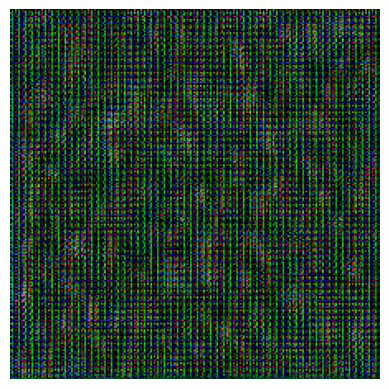

In [17]:
class Visualizer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Visualizer, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Use Tanh to output between -1 and 1
        )
        # Move the deconvolution layers to the same device as the input tensor
        self.deconv.to(device)

    def forward(self, x):
        return self.deconv(x)


def generate_image_for_class(model, target_class_name, layer_id=0):
    # Get the index of the target class
    target_class_index = class_names.index(target_class_name)

    # Generate a placeholder image with random noise
    placeholder_image = torch.randn(1, 3, 224, 224).to(device)

    # Forward pass through the model to get activations
    model.to(device)  # Move the model to the same device as the input tensor
    placeholder_image = placeholder_image.to(device)
    model(placeholder_image)
    activations = model.activations

    # Select activation from desired layer
    activation = activations[layer_id]

    print("Activation size:", activation.size())

    # Create visualizer for this layer's feature maps
    visualizer = Visualizer(activation.size(1), 3)  # Assuming RGB visualization

    # Deconvolve the activation to get the reconstructed image
    reconstructed_image = visualizer(activation)

    # Plot the reconstructed image
    plt.imshow(reconstructed_image.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
    plt.axis('off')
    plt.show()

generate_image_for_class(model, target_class_name="altar")


In [18]:
import torch.nn as nn

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)  # Adjusted stride for the first layer
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.activations = []  # List to store intermediate feature maps

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        self.activations = []  # Clear activations list before forward pass
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer0(x)
        self.activations.append(x)  # Store activation after layer0

        x = self.layer1(x)
        self.activations.append(x)  # Store activation after layer1

        x = self.layer2(x)
        self.activations.append(x)  # Store activation after layer2

        x = self.layer3(x)
        self.activations.append(x)  # Store activation after layer3

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [20]:
num_classes = 10
num_epochs = 5
batch_size = 16
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

In [21]:
import matplotlib.pyplot as plt

# Lists to store loss and accuracy values
train_loss_values = []
train_accuracy_values = []
valid_accuracy_values = []

for epoch in range(num_epochs):
    # Variables to track loss and accuracy for the current epoch
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        epoch_train_loss += loss.item()
        
        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Compute average loss and accuracy for the epoch
    epoch_train_loss /= len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_values.append(epoch_train_loss)
    train_accuracy_values.append(train_accuracy)
    
    # Validation
    with torch.no_grad():
        correct_valid = 0
        total_valid = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
        
        valid_accuracy = 100 * correct_valid / total_valid
        valid_accuracy_values.append(valid_accuracy)

    print ('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%' 
           .format(epoch+1, num_epochs, epoch_train_loss, train_accuracy, valid_accuracy))
    

Epoch [1/5], Train Loss: 1.6013, Train Accuracy: 42.90%, Validation Accuracy: 58.24%
Epoch [2/5], Train Loss: 1.1620, Train Accuracy: 59.42%, Validation Accuracy: 68.02%
Epoch [3/5], Train Loss: 0.9156, Train Accuracy: 69.08%, Validation Accuracy: 73.25%
Epoch [4/5], Train Loss: 0.7678, Train Accuracy: 73.70%, Validation Accuracy: 77.69%
Epoch [5/5], Train Loss: 0.5906, Train Accuracy: 80.23%, Validation Accuracy: 79.57%


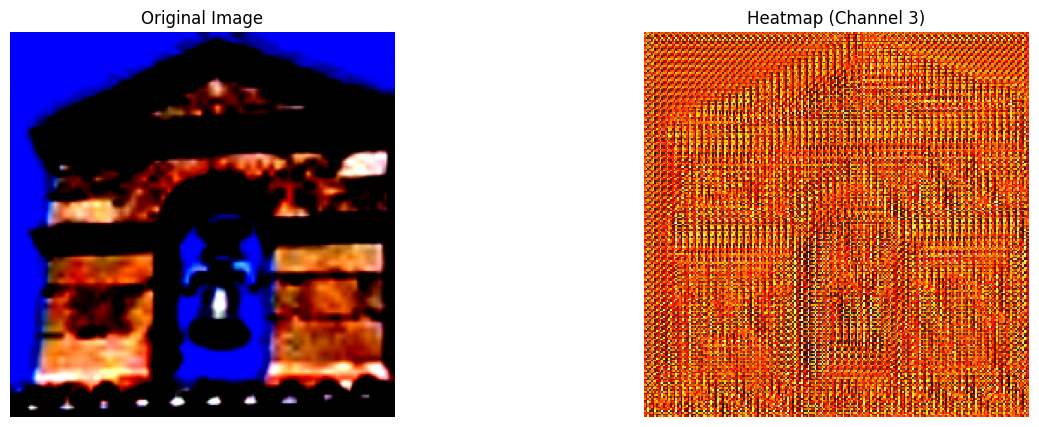

In [22]:
import matplotlib.pyplot as plt
class Visualizer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Visualizer, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()  # Use sigmoid for visualization between 0 and 1
        )
        # Move the deconvolution layers to the same device as the input tensor
        self.deconv.to(device)

    def forward(self, x):
        return self.deconv(x)


def visualize_feature_maps(model, image, layer_id=0):
    # Forward pass through the model to get activations
    model(image)
    activations = model.activations

    # Select activation from desired layer
    activation = activations[layer_id]

    # Create visualizer for this layer's feature maps
    visualizer = Visualizer(activation.size(1), 3)  # Assuming RGB visualization

    # Ensure the activation tensor has the correct shape
    activation = activation.unsqueeze(0) if activation.dim() == 3 else activation

    # Deconvolve the activation to get visualized feature maps
    visualized_maps = visualizer(activation)

    # You can now visualize or save the "visualized_maps" tensor
    return visualized_maps




# Move the input tensor to the same device as the model
for images, _ in test_loader:
    image = images[0]  # Selecting the first image for visualization
    break
# Visualize feature maps
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device as the input tensor
model.to(device)
image = image.unsqueeze(0).to(device)  # Add a batch dimension and move to device



def plot_heatmap_with_image(heatmap, image, cmap='viridis', alpha=0.6, vmin=None, vmax=None):
    # Convert feature maps to numpy array
    heatmap_numpy = heatmap.cpu().detach().numpy()

    # Squeeze the first dimension of the image tensor
    image_numpy = image.squeeze(0).cpu().detach().numpy()

    # Plot the heatmap
    plt.figure(figsize=(15, 5))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_numpy.transpose(1, 2, 0))
    plt.title('Original Image')
    plt.axis('off')

    # Plot each channel of the feature maps separately
    num_channels = heatmap_numpy.shape[1]
    plt.subplot(1, 2, 2)
    for i in range(num_channels):
        heatmap_channel = heatmap_numpy[0, i, :, :]
        plt.imshow(heatmap_channel, cmap=cmap, interpolation='nearest', alpha=alpha, vmin=vmin, vmax=vmax)
        plt.title(f'Heatmap (Channel {i+1})')
        plt.axis('off')

    plt.show()


visualized_feature_maps = visualize_feature_maps(model, image, layer_id=1)

# Plot the heatmap with the original image
plot_heatmap_with_image(visualized_feature_maps, image, cmap='hot', alpha=0.8, vmin=0.2, vmax=0.8)

Activation size: torch.Size([1, 64, 112, 112])


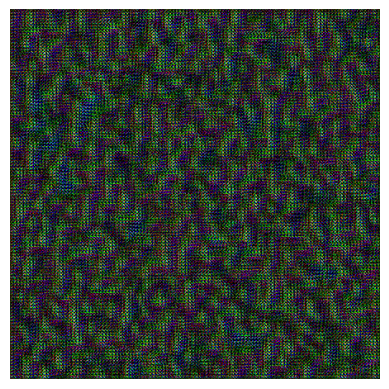

In [23]:
class Visualizer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Visualizer, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Use Tanh to output between -1 and 1
        )
        # Move the deconvolution layers to the same device as the input tensor
        self.deconv.to(device)

    def forward(self, x):
        return self.deconv(x)


def generate_image_for_class(model, target_class_name, layer_id=0):
    # Get the index of the target class
    target_class_index = class_names.index(target_class_name)

    # Generate a placeholder image with random noise
    placeholder_image = torch.randn(1, 3, 224, 224).to(device)

    # Forward pass through the model to get activations
    model.to(device)  # Move the model to the same device as the input tensor
    placeholder_image = placeholder_image.to(device)
    model(placeholder_image)
    activations = model.activations

    # Select activation from desired layer
    activation = activations[layer_id]

    print("Activation size:", activation.size())

    # Create visualizer for this layer's feature maps
    visualizer = Visualizer(activation.size(1), 3)  # Assuming RGB visualization

    # Deconvolve the activation to get the reconstructed image
    reconstructed_image = visualizer(activation)

    # Plot the reconstructed image
    plt.imshow(reconstructed_image.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
    plt.axis('off')
    plt.show()

generate_image_for_class(model, target_class_name="altar")
